# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import random

from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

1.4.0


In [2]:
torch.cuda.device_count()

1

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Double-Deep-Q-Network approach
1. Define a DNN model 
2. Build the agent

#### DNN model for the Double-DQN

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers = [128, 128, 128], drop_p = 0.1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_layers (list of int):  list of integers, amount and size of the hidden layers
            drop_p (float): dropout probability
            
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)

        # add the first layer: input to first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # add a viariable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # add the last layer: last hidden to output
        self.output = nn.Linear(hidden_layers[-1], action_size)
        
        # dropout probabilities
        self.drop_p = drop_p

    def forward(self, x):
        """Build a network that maps state -> action values."""
        
        # Forward through each layer in the hidden_layers, with ReLU activation and dropouts
        for linear in self.hidden_layers:
            x = linear(x)
            x = F.relu(x)
            x = F.dropout(x, p = self.drop_p)
            
        x = self.output(x)
        
        return(x)

#### Double-DQN Agent

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network -> this is variable C within the DQN paper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)

        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)


        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        """Update the relay memory and update everey UPDATE_EVERY steps the weights
        
        Params
        ======
        
            state (): 
            action():
            reward ():
            next_state ():
            done ():
        
        
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                # return statement for debug purposes
                # return(self.learn(experiences, GAMMA))

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # get the state as a torch tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # set network into evaluation mode -> turn off dropout!
        self.qnetwork_local.eval()
        # turn off gradient computation outside training mode -> safes memory & computations
        with torch.no_grad():
            # get the action values due to a forward pass of the state through the network!
            action_values = self.qnetwork_local(state)
        # set network back into training mode -> turn on dropout!
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            # return the action with the biggest q-value
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # return a random uniformly distributed value out of the action space
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        
           Double-Deep-Q-Network implementation according to van Hasselt et al., 2015

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        
        """ Compute Q targets for next states 
        
            For the Double-Deep-Q-Networt implementation: 
        
            1. Get the indices of the max predicted Q values for the next states from the online model / online network 
            2. Use these indices to get the max Q values from the target model / target network
        
            detach(): return a new Tensor (it does not change the current one) that does not share the history of the 
            original Tensor / detached from the current graph.(no autograd)
            .detach() returns a new tensor without history!
            
            torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor): Returns a namedtuple (values, indices) where values is the maximum 
            value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).
            .max(1)[0] returns the maximum value of the 1st dimension
            
            torch.unsqueeze(input, dim, out=None) → Tensor: Returns a new tensor with a dimension of size one inserted at the specified position.
            .unsqueeze(1) transform the data from a row-vector into a column vector
            
            Q_targets_next is a column vector of size BATCH_SIZE with the max action values from each forwarded next_state!
       
        """
        # Get the index of the max value but NOT the value from qnetwork_local 
        Q_expected_next_index = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        
        # Use these indices to get the max Q values from the target model / target network
        Q_targets_next = self.qnetwork_target(next_states).gather(1, Q_expected_next_index)
        
        
        """ Compute Q targets for current states:
            
            Use Q_targets_next to compute the current Q targets
        
            if done == 1 there will be no next state -> Q_targets is just the reward
            otherwise it's the immediate reward + discount factor * the estimated Q_target of the next state
            Q_targets is a column vector of size BATCH_SIZE with the computed values of the immediate reward and the Q-values (action-values) of the next state
            
        """
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))


        """ Get expected Q values from local model
        
            Q_expected_full_values has the Q-values / action values of a pass trough / forward run throug the network qnetwork_local
            Q_expected_full_values has dimension 0 = BATCH_SIZE and dimension 1 = size of action space
            
            torch.gather(input, dim, index, out=None, sparse_grad=False) → Tensor: Gathers values along an axis specified by dim.
            gather(1, actions) extracts the values out of Q_expected_full_values at the position specified in action! 
            If action has value 3 -> get the value from index 3 out of Q_expected_full_values
            Q_expected has dimension 0 = BATCH_SIZE and dimension 1 = 1
        
        """
        # Get all Q-values of qnetwork_local
        Q_expected_full_values = self.qnetwork_local(states)
        
        # Extract the Q-values accorting to actions (=indices of the values)
        Q_expected = Q_expected_full_values.gather(1, actions)
        
        # The two previous steps can be done within one step
        # Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss -> use the mean sqared error loss function (from torch.nn.functional)
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        # Clear the gradients, because backward accumulates the gradients and so they have to be cleared
        self.optimizer.zero_grad()
        # calculate the gradients
        loss.backward()
        # update the weights / parameter
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)          

        # return statement for debug purposes
        # return(Q_expected_full_values)                  

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### Init Agent

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
state = env_info.vector_observations[0]             # get the next state
score = 0
# watch an untrained agent
for j in range(200):
    action = agent.act(state)
#     action = 2
#     print(action)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
#     print('state', state)
#     print('reward', reward)
#     print('done', done)
    if done:
        break 
    
# print("Score: {}".format(score))

In [10]:
# env.close()

###  Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: 0.12
Episode 200	Average Score: 0.96
Episode 300	Average Score: 4.37
Episode 400	Average Score: 8.99
Episode 500	Average Score: 11.58
Episode 544	Average Score: 13.06
Environment solved in 444 episodes!	Average Score: 13.06


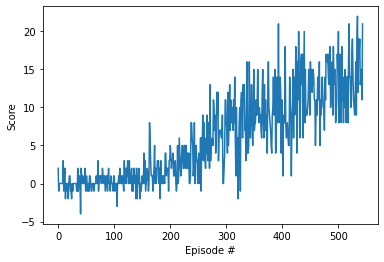

In [11]:
def dqn(n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]             # get the next state

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
#             action = agent.act(state)
#             next_state, reward, done, _ = env.step(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
#             # return value(s) for debug purposes
#             ret = agent.step(state, action, reward, next_state, done)
#             if ret != None:
#                 print(ret)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:
                break
                
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [15]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]             # get the next state
    score = 0
    
    for j in range(400):
        action = agent.act(state)
#         print('action', action)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations[0]        # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
#         time.sleep(0.05)

        if done:
            print('In run {} the agent got a reward of {}!'.format(i+1, score))
            break 
            
# env.close()

In run 1 the agent got a reward of 15.0!
In run 2 the agent got a reward of 13.0!
In run 3 the agent got a reward of 16.0!
In run 4 the agent got a reward of 13.0!
In run 5 the agent got a reward of 14.0!


In [16]:
env.close()